In [2]:
import pandas as pd

In [3]:
gov_df = pd.read_csv('../../data/raw/nyc_gov_pothole.csv')
request_df = pd.read_csv('../../data/raw/nyc_311_pothole.csv')

In [4]:
gov_df = gov_df.rename(columns={'OnPrimName' : "street_name", "RptDate" : "created_date"})
print(gov_df.columns)

Index(['DefNum', 'the_geom', 'created_date', 'RptClosed', 'street_name'], dtype='object')


In [5]:
request_df['created_date'] = pd.to_datetime(request_df['created_date'])
request_df['month'] = request_df['created_date'].dt.to_period("M")

gov_df['created_date'] = pd.to_datetime(gov_df['created_date'])
gov_df['month'] = gov_df['created_date'].dt.to_period("M")

In [6]:
user_complaints_by_street_month = (
    request_df.groupby(['street_name', 'month']).size().reset_index(name='complaints_count')
)

govt_actions_by_street_month = (
    gov_df.groupby(['street_name', 'month']).size().reset_index(name='action_count')
)
merged_df = pd.merge(user_complaints_by_street_month, govt_actions_by_street_month, on=['street_name', 'month'], how='outer')
merged_df = merged_df.fillna(0)

In [7]:
merged_df = pd.merge(user_complaints_by_street_month, govt_actions_by_street_month, on=['street_name', 'month'], how='outer')
merged_df = merged_df.fillna(0)

In [8]:
merged_df['action_delta'] = merged_df['complaints_count'] - merged_df['action_count']

In [9]:
merged_df = merged_df.sort_values(by='action_delta', ascending=False)

In [10]:
merged_df.to_csv("../../data/processed/aggregated_pothole.csv")

In [11]:
from tabulate import tabulate

In [12]:
print(tabulate(merged_df.head(15), headers='keys', tablefmt="psql", showindex=False))

+------------------+---------+--------------------+----------------+----------------+
| street_name      | month   |   complaints_count |   action_count |   action_delta |
|------------------+---------+--------------------+----------------+----------------|
| EAST   31 STREET | 2023-04 |                260 |              0 |            260 |
| OCEAN PARKWAY    | 2018-08 |                172 |              7 |            165 |
| OCEAN PARKWAY    | 2015-03 |                249 |            105 |            144 |
| MC DONALD AVENUE | 2019-03 |                131 |              0 |            131 |
| RAMONA AVENUE    | 2022-03 |                124 |              1 |            123 |
| FLATBUSH AVENUE  | 2014-05 |                103 |             21 |             82 |
| ARTHUR KILL ROAD | 2014-05 |                 95 |             15 |             80 |
| OCEAN PARKWAY    | 2015-04 |                119 |             40 |             79 |
| SHORE ROAD       | 2016-07 |                 80 |   

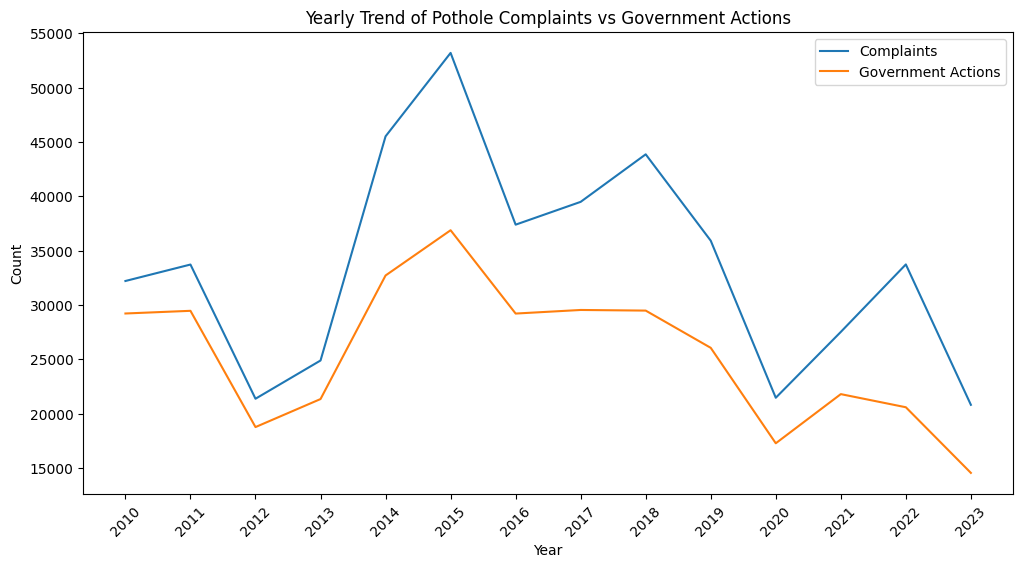

In [13]:
import matplotlib.pyplot as plt

# Extract year from 'month' for aggregation
merged_df['year'] = pd.to_datetime(merged_df['month'].astype(str)).dt.year

# Aggregate data by year
yearly_data = merged_df.groupby('year').agg({'complaints_count': 'sum', 'action_count': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['year'], yearly_data['complaints_count'], label='Complaints')
plt.plot(yearly_data['year'], yearly_data['action_count'], label='Government Actions')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Trend of Pothole Complaints vs Government Actions')
plt.legend()
plt.xticks(yearly_data['year'], rotation=45)  # Ensure all years are displayed as x-ticks

plt.show()
